# Fit dependent Gaussian timeseries with an RNN

In [1]:
from IPython.display import Markdown

import math
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.distributions import MultivariateNormal
from torch.utils.data import DataLoader, TensorDataset

import pyro

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
import colorcet as cc

import scipy
from scipy.linalg import toeplitz

If possible we train the network on the GPU.

In [2]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## Generate training data: bivariate Gaussian process


In [3]:
kappa = 0.5
lamda = 1.0
rho = 1.0
mu = 1.0

sigma_ss = kappa / lamda
sigma_sx = rho * sigma_ss / (lamda + mu)
sigma_xx = rho / mu * (sigma_ss + sigma_sx)

In [4]:
def exp2(x, decay, scale):
    return scale * (-decay * x).exp()

def exprel(x):
    return torch.where(x.abs() > 1e-15, torch.special.expm1(x) / x, 1.0)

def cov_ss(t):
    return exp2(t, lamda, sigma_ss)

def cov_sx(t):
    scale1 = rho * sigma_ss * t * exprel((lamda - mu) * t)
    return exp2(t, mu, sigma_sx) + exp2(t, lamda, scale1)

def cov_xs(t):
    return exp2(t, lamda, sigma_sx)

def cov_xx(t):
    scale1 = rho * sigma_sx * t * exprel((lamda - mu) * t)
    return exp2(t, lamda, scale1) + exp2(t, mu, sigma_xx)

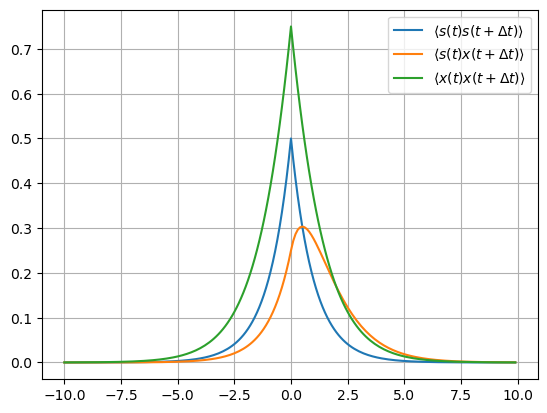

In [9]:
t = torch.arange(-10, 10, 1e-1)
plt.plot(t, cov_ss(t.abs()), label='$\\langle s(t) s(t+\\Delta t)\\rangle$')
plt.plot(t, torch.where(t >= 0, cov_sx(t), cov_xs(-t)), label='$\\langle s(t) x(t+\\Delta t)\\rangle$')
plt.plot(t, cov_xx(t.abs()), label='$\\langle x(t) x(t+\\Delta t)\\rangle$')
plt.legend()
plt.grid();

Assemble the covariance matrix of the joint process

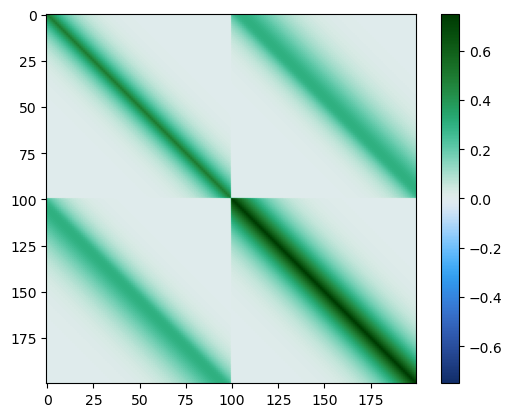

In [10]:
duration = 10.0
delta_t = 1e-1

t = torch.arange(0.0, duration, delta_t)

cov_mat_ss = toeplitz(cov_ss(t), cov_ss(t))
cov_mat_xs = toeplitz(cov_sx(t), cov_xs(t))
cov_mat_sx = toeplitz(cov_xs(t), cov_sx(t))
cov_mat_xx = toeplitz(cov_xx(t), cov_xx(t))

cov_mat_z = np.block([[cov_mat_ss, cov_mat_sx], 
                      [cov_mat_xs, cov_mat_xx]])
plt.imshow(cov_mat_z, norm=colors.CenteredNorm(), cmap=cc.m_CET_D13)
plt.colorbar()

### Prepare training data

In [11]:
cov_mat = torch.tensor(cov_mat_z, device=device)
dist = MultivariateNormal(torch.zeros(cov_mat.size(0), device=device), cov_mat)
data = dist.sample((1_000,)).reshape((-1, 2, cov_mat.size(0) // 2))

In [12]:
val_data = dist.sample((10_000,)).reshape((-1, 2, cov_mat.size(0) // 2))

In [13]:
data.size(), val_data.size()

(torch.Size([1000, 2, 100]), torch.Size([10000, 2, 100]))

In [14]:
def make_input_and_target(data):
    s_series = data[:,0,:]
    x_series = data[:,1,:]

    # we need to shift the output by one wrt the input
    x_lagged = torch.roll(x_series, 1, dims=-1)
    x_lagged[..., 0] = 0.0

    input = torch.cat((s_series.unsqueeze(-1), x_lagged.unsqueeze(-1)), dim=-1)
    target = x_series.unsqueeze(-1)
    
    return input, target

In [15]:
input, target = make_input_and_target(data)
val_input, val_target = make_input_and_target(val_data)

train_ds = TensorDataset(input, target)
valid_ds = TensorDataset(val_input, val_target)

input.size(), target.size(), val_input.size(), val_target.size()

(torch.Size([1000, 100, 2]),
 torch.Size([1000, 100, 1]),
 torch.Size([10000, 100, 2]),
 torch.Size([10000, 100, 1]))

### Visualize Training Data

We have $N$ samples of time series of length $L$ (sampled at a frequency $f_s=1/\Delta t$). We denote by $x[i,j]$ the $j$-th time step of the $i$-th time series. The cross-correlation between $x$ and $y$ is
$$
C[k] = \frac{1}{N} \sum_i \sum_j x[i,j]\ y[i,j+k] = \frac{1}{N} \sum_i x[i] \star y[i]
$$
where $k$ ranges from $-L,\ldots,0,\ldots,L$ and $\star$ is the convolution operator.

In [160]:
# estimate correlation from data
def cross_corr(x, y):
    N = x.shape[-1]
    x = x.unsqueeze(1)
    y = y.unsqueeze(0)
    result = F.conv1d(y, x, padding=N, groups=y.shape[1]).squeeze(0)
    return torch.arange(-N,N+1), result.mean(dim=0).cpu()

def cross_corr_full(data, transpose=False):
    if transpose:
        data = data.transpose(0, 1)
    N, L = data.shape[1:]
    result = F.conv1d(data, data, padding=L) / N
    return torch.arange(-L,L+1), result.transpose(0, 1).cpu()

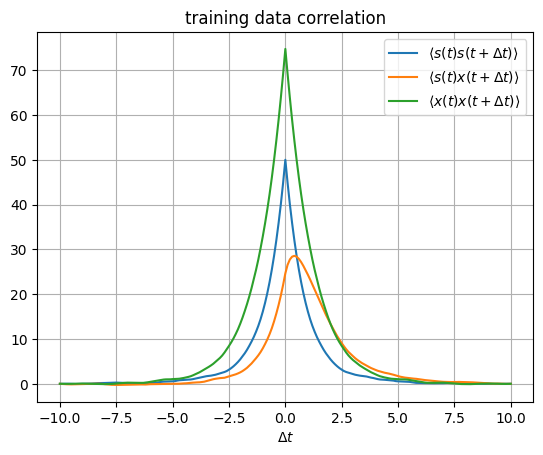

In [161]:
def plot_cross_corr(data):
    lags, corr = cross_corr_full(data)
    plt.plot(lags * delta_t, corr[0, 0], label="$\\langle s(t) s(t+\Delta t)\\rangle$")
    plt.plot(lags * delta_t, corr[0, 1], label="$\\langle s(t) x(t+\Delta t)\\rangle$")
    plt.plot(lags * delta_t, corr[1, 1], label="$\\langle x(t) x(t+\Delta t)\\rangle$")
    plt.xlabel("$\Delta t$")
    plt.grid()
    plt.legend()

plot_cross_corr(data.transpose(0, 1))
plt.title("training data correlation");

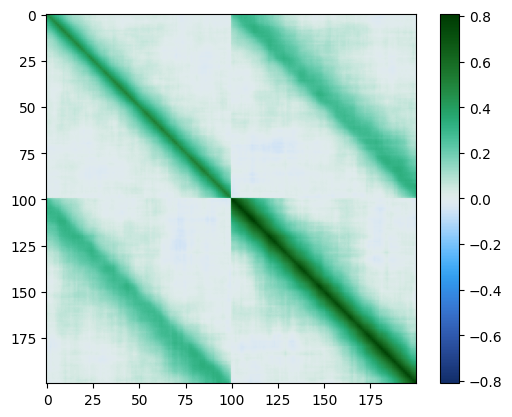

In [162]:
def plot_correlations(input, output):
    data = torch.cat((input.T, output.T), dim=0)
    plt.imshow(torch.cov(data).cpu(), norm=colors.CenteredNorm(), cmap=cc.m_CET_D13)
    plt.colorbar()
    
plot_correlations(data[:,0,:], data[:,1,:])

### Gaussian Information

In [163]:
s_vec = data[:,0,:].reshape((-1,))
x_vec = data[:,1,:].reshape((-1,))
inst_cov = torch.cov(torch.stack((s_vec, x_vec)))
instantaneous_mi = 0.5 * (inst_cov.diag().log().sum() - inst_cov.logdet())
instantaneous_mi

tensor(0.0888, device='cuda:0')

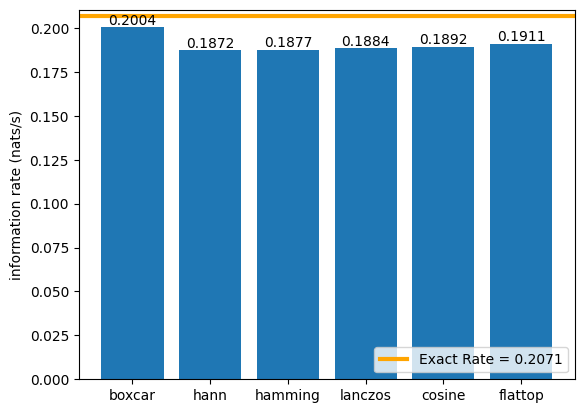

In [164]:
def tostevin_information_rate(s_data, x_data, window='hann', nfft=None):    
    freq, spectrum_ss = scipy.signal.welch(
        s_data, 
        fs=1/delta_t, 
        nperseg=s_data.shape[-1], 
        return_onesided=False, 
        detrend=False,
        window=window,
        nfft=nfft
    )
    spectrum_ss = np.mean(spectrum_ss, axis=0)

    freq, spectrum_xx = scipy.signal.welch(
        x_data, 
        fs=1/delta_t, 
        nperseg=x_data.shape[-1], 
        return_onesided=False, 
        detrend=False,
        window=window,
        nfft=nfft
    )
    spectrum_xx = np.mean(spectrum_xx, axis=0)

    freq, spectrum_sx = scipy.signal.csd(
        s_data, x_data,
        fs = 1/delta_t,
        nperseg=s_data.shape[-1],
        detrend=False,
        return_onesided=False,
        window=window,
        nfft=nfft
    )
    spectrum_sx = np.mean(spectrum_sx, axis=0)
    
    omega = 2*np.pi*freq
    
    integrand = - 1/(4*np.pi) * np.log(1 - (np.abs(spectrum_sx)**2)/(spectrum_ss * spectrum_xx))
    # plt.plot(scipy.fft.fftshift(omega), scipy.fft.fftshift(integrand))
    # plt.grid()
    val = scipy.integrate.trapezoid(scipy.fft.fftshift(integrand), x=scipy.fft.fftshift(omega))
    return float(val)

windows = ['boxcar', 'hann', 'hamming', 'lanczos', 'cosine', 'flattop']
values = []
for window in windows:
    tost = tostevin_information_rate(data[:,0,:].cpu(), data[:,1,:].cpu(), window=window)
    values.append(tost)
    
exact_rate = lamda/2 * (np.sqrt(1 + rho/lamda) - 1)

b = plt.bar(windows, values)
b2 = plt.axhline(exact_rate, linewidth=3, color='orange', label=f"Exact Rate = {exact_rate:.4}")

# plt.title("Gaussian Rate estimates")
plt.ylabel("information rate (nats/s)")
plt.legend(loc="lower right")
plt.bar_label(b, fmt='%.4f');

## Fitting a RNN model

### Set Hyperparameters

In [219]:
hidden_size = 64
num_layers = 1
num_batches = data.size(0)

### Define RNN model

Create a new model (called `Sequence`) based on a LSTM and a linear output layer.

In [233]:
class Sequence(nn.Module):
    def __init__(self, hidden_size=hidden_size, num_layers=num_layers):
        super().__init__()
        # create an LSTM with 2 input features
        self.lstm = nn.GRU(2, hidden_size, num_layers, batch_first=True)
        # create output layer with 2 features (mean, var)
        self.linear = nn.Linear(hidden_size+1, 2)
        
    def init_hidden(self, batches=num_batches, device=device):
        h_t = torch.zeros(num_layers, batches, hidden_size, device=device)
        # c_t = torch.zeros(num_layers, batches, hidden_size, device=device)
        return h_t#, c_t

    def forward(self, input, hidden=None):
        output, hidden = self.lstm(input, hidden)
        mean, log_var = self.linear(torch.cat((output, input[...,[0]]), dim=-1)).split(1, dim=-1)
        outputs = torch.cat((mean, log_var.exp()), dim=-1)
        return outputs, hidden

initialize the model

In [234]:
model = Sequence().to(device)
losses = []
model

Sequence(
  (lstm): GRU(2, 64, batch_first=True)
  (linear): Linear(in_features=65, out_features=2, bias=True)
)

### Train the model

In [235]:
def get_data(train_ds, valid_ds, bs=512):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs*4)
    )

In [236]:
def loss_batch(model, loss_func, input, target, opt=None):
    hidden = model.init_hidden(input.size(0))
    output, hidden = model(input, hidden)
    mean, var = output.split(1, dim=-1)
    loss = loss_func(mean, target, var)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(input)

In [237]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(1, epochs+1):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            batch_losses, nums = zip(*[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl])
        val_loss = np.dot(batch_losses, nums) / np.sum(nums)
        losses.append(val_loss)
        
        epoch % 100 == 0 and print(epoch, val_loss)

In [238]:
epochs = 400
loss_func = nn.GaussianNLLLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [239]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs=32)
fit(epochs, model, loss_func, optimizer, train_dl, valid_dl)

100 -0.6840422211647034
200 -0.6875138687133789
300 -0.6887268186569214
400 -0.6891285331726075


We initialize the model.

Then we are ready to perform the main training loop.

After training, we can plot the losses as a function of training epochs.

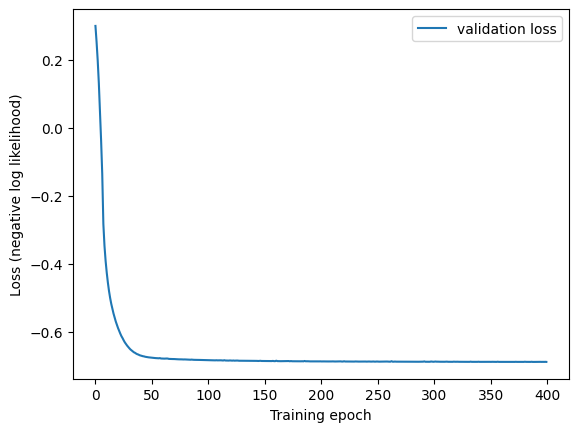

In [240]:
plt.plot(losses, label="validation loss")
plt.xlabel("Training epoch")
plt.ylabel("Loss (negative log likelihood)")
plt.legend();

### Load model from file

In [246]:
# torch.save(model, "model.pth")

In [19]:
model = torch.load("model.pth").to(device)
model

Sequence(
  (lstm): LSTM(2, 8, batch_first=True)
  (linear): Linear(in_features=9, out_features=2, bias=True)
)

### Evaluate the trained model

In [241]:
# input is a (N, L) tensor where N are the number of batches and L is the length
def generate(input):
    N, L = input.size()
    model.eval()
    with torch.no_grad():
        # the first x-value we feed into the RNN is zero, consistent with the training eamples
        pred = torch.zeros((N, 1, 1), device=device)
        hidden = model.init_hidden(N)
        predictions = []
        h_n = [hidden]
        for i in range(L):
            inp = torch.cat((input[:, i].reshape((N, 1, 1)), pred), dim=-1)
            
            output, hidden = model(inp, hidden)
            pred_mean, pred_var = output.split(1, dim=-1)
            pred = torch.normal(pred_mean, pred_var.sqrt())
            
            predictions.append(pred)
            h_n.append(hidden)
        predictions = torch.cat(predictions, dim=1).squeeze(2)
        
        return predictions, h_n
        

Generate a new trajectory from the learned model.

In [242]:
eval_data, _ = generate(val_input[:,:,0].to(device))
eval_data = eval_data.cpu()
eval_data.size()

torch.Size([10000, 100])

And plot its time trace

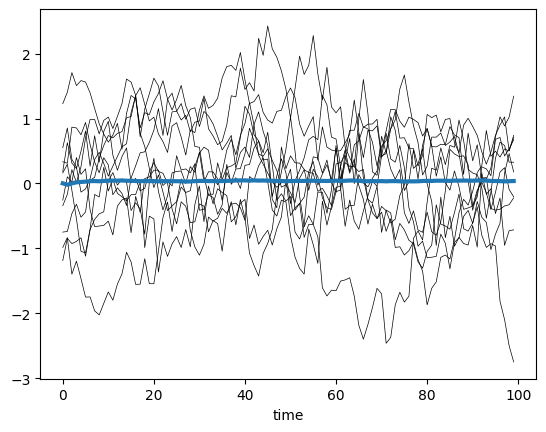

In [243]:
plt.plot(eval_data[np.arange(10), :].numpy().T, color="black", linewidth=0.5)
plt.plot(eval_data.mean(dim=0).squeeze(0), linewidth=3.0)
plt.xlabel("time");

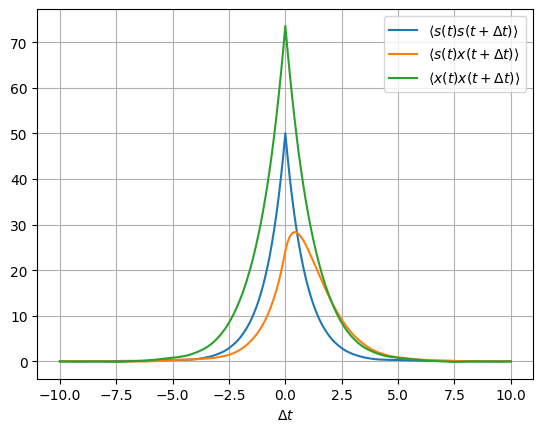

In [244]:
plot_cross_corr(torch.stack((val_data[:,0,:].cpu(), eval_data)))

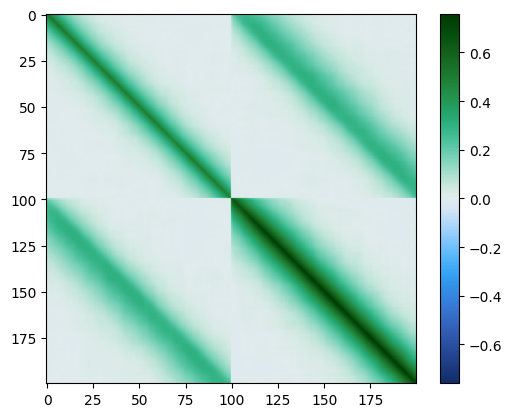

In [245]:
plot_correlations(val_data[:,0,:].cpu(), eval_data)

### Visualize hidden state

In [25]:
h_tensor = torch.cat([torch.cat(h, dim=-1) for h in h_n], dim=0)

NameError: name 'h_n' is not defined

In [985]:
h_tensor.size()

torch.Size([101, 10000, 16])

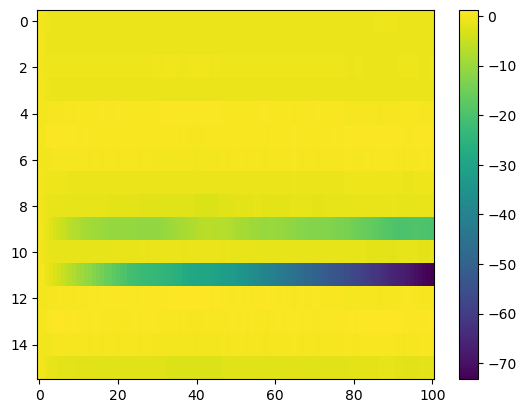

In [987]:
plt.imshow(h_tensor[:,1,:].T, aspect='auto')
plt.colorbar()

In [438]:
h_tensor.diff(dim=0)[100:150,0,:].T

tensor([], size=(16, 0))

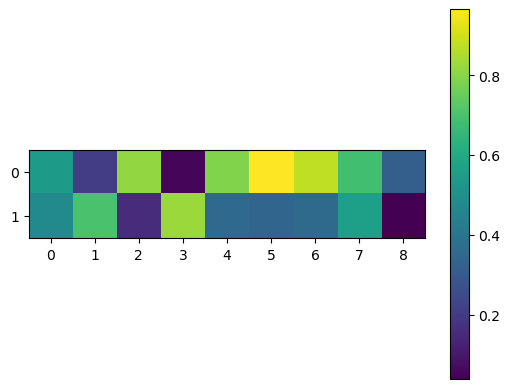

In [922]:
plt.imshow(model.linear.get_parameter("weight").detach().abs())
plt.colorbar();

## PWS

In [26]:
def log_likelihood(input, output):
    L = input.size(-1)
    
    # we need to shift the output by one wrt the input
    output_lagged = torch.roll(output, 1, dims=-1)
    output_lagged[..., 0] = 0.0
    
    model_data = torch.cat((input.unsqueeze(-1), output_lagged.expand(input.shape).unsqueeze(-1)), dim=-1)
    batch_shape = model_data.shape[:-2]
    
    flat_model_data = model_data.reshape((-1, L, 2))
    
    hidden = model.init_hidden(flat_model_data.shape[0])
    result, hidden = model(flat_model_data, hidden)
    pred_mean, pred_var = result.split(1, dim=-1)

    pred_mean = pred_mean.reshape(batch_shape + (L,)).cpu()
    pred_var = pred_var.reshape(batch_shape + (L,)).cpu()
    
    nll = F.gaussian_nll_loss(pred_mean, output.cpu(), pred_var, full=True, reduction='none')
        
    return -nll.cumsum(dim=-1)

In [27]:
def circ_indices(size):
    ind = torch.cat([torch.arange(size), torch.arange(size-1)], 0)
    return ind.as_strided((size, size), (1,1)).clone()

In [34]:
def log_evidence(input, output):
    N, L = input.size()

    tiled_input = input.tile([2, 1]).contiguous()
    
    accumulator = torch.zeros((N, L)).log()

    with torch.no_grad():
        for i in range(N):
            shifted_input = tiled_input.narrow(0, i, N)
            ll = log_likelihood(shifted_input, output).cpu()
            torch.logaddexp(accumulator, ll, out=accumulator)
    
    return accumulator - torch.log(torch.tensor(N))

In [39]:
ll = log_likelihood(data[:,0,:].to(device), data[:,1,:].to(device)).detach().cpu()
ll.size()

torch.Size([1000, 100])

In [44]:
le = log_evidence(data[:,0,:].to(device), data[:,1,:].to(device)).detach().cpu()
le.size()

torch.Size([1000, 100])

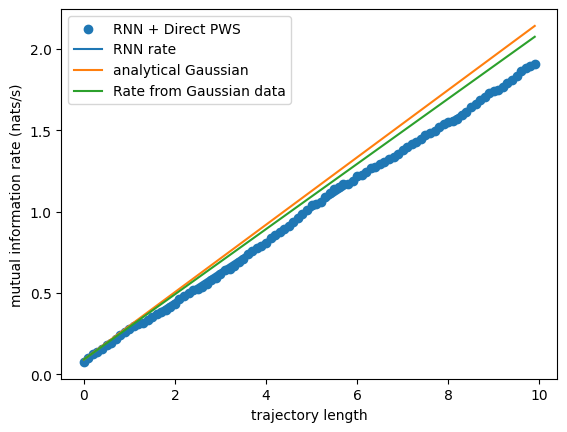

In [43]:
t = np.arange(0, duration, delta_t)
plt.scatter(t, torch.mean(ll - le, dim=0), label = "RNN + Direct PWS")

rnn_rate = torch.mean(torch.diff(torch.mean(ll - le, dim=0))[10:]).numpy() / delta_t

plt.plot(t, instantaneous_mi + t * rnn_rate, label = "RNN rate")
plt.plot(t, instantaneous_mi + t * lamda/2 * (np.sqrt(1 + rho/lamda) - 1), label = "analytical Gaussian")
plt.plot(t, instantaneous_mi + t * tostevin_information_rate(data[:,0,:], data[:,1,:]), label="Rate from Gaussian data")
plt.xlabel("trajectory length")
plt.ylabel("mutual information rate (nats/s)")
plt.legend();

## Variational Inference

In [45]:
class VariationalEncoder(nn.Module):
    def __init__(self, L):
        super(VariationalEncoder, self).__init__()
        self.linear = nn.Linear(L, L, bias=False)
        self.sigma = nn.Parameter(data=torch.eye(L))
        self.N = torch.distributions.MultivariateNormal(torch.zeros(L), torch.eye(L))
        self.log_prob = 0

    def forward(self, x, num_particles=1):
        batch_shape = ()
        if num_particles > 1:
            batch_shape = (num_particles,) + batch_shape
        mean_s = self.linear(x)
        dist = torch.distributions.MultivariateNormal(mean_s, scale_tril=self.sigma)
        s = dist.sample(batch_shape)
        self.log_prob = dist.log_prob(s)
        return s

In [391]:
var_enc = VariationalEncoder(100)
var_enc(data[:,1,:], num_particles=1).size()

torch.Size([1000, 100])

In [393]:
var_enc.log_prob.size()

torch.Size([1000])

# Pyro

The predictive model is a function that gives the likelihood of observing `data`.

In [46]:
def predictive_model(data, subsample=None):
    N, L = data.shape
    
    s_dist = pyro.distributions.MultivariateNormal(
        torch.zeros((L,), device=device), 
        torch.tensor(cov_mat_ss, device=device)
    )
    
    model.train()
    
    with pyro.plate("N", N, subsample_size=subsample) as ind:        
        s = pyro.sample("s_traj", s_dist)
        s = s.unsqueeze(-1)
        
        x = data[..., ind, :]
        
        # we need to shift the output by one wrt the input
        x_lagged = torch.roll(x, 1, dims=-1)
        x_lagged[..., 0] = 0.0
        x_lagged = x_lagged.unsqueeze(-1).expand(s.shape)
        
        model_input = torch.cat((s, x_lagged), dim=-1)
        batch_shape = model_input.shape[:-2]
        
        model_input = model_input.reshape((-1, L, 2))
        hidden = model.init_hidden(model_input.shape[0])
        
        output, hidden = model(model_input, hidden)

        pred_mean, pred_var = output.split(1, dim=-1)
        pred_mean = pred_mean.reshape(batch_shape + (L,))
        pred_var = pred_var.reshape(batch_shape + (L,))
    
        obs_dist = pyro.distributions.Normal(pred_mean, pred_var.sqrt()).to_event(1)
        
        pred = pyro.sample("pred", obs_dist, obs=x)
    
#     predictions = []
#     h_n = [hidden]
#     for i in range(L):
#         inp = torch.cat((input[..., [i]], pred), dim=-1)

#         output, hidden = model(inp, hidden)
#         pred_mean, pred_var = output.split(1, dim=-1)

#         obs = data[:, i] if data[0] is not None else None
#         with pyro.plate(f"data_loop_{i}", N):
#             pred = pyro.sample(f"pred_{i}", pyro.distributions.Normal(pred_mean[:,0,0], pred_var.sqrt()[:,0,0]), obs=obs)

#         pred = pred.reshape((N, 1, 1))
#         predictions.append(pred)
            
#     predictions = torch.cat(predictions, dim=1).squeeze(2)

    return pred
        
    

In [47]:
predictive_model(data[:,1,:].to(device)).size()

torch.Size([1000, 100])

In [210]:
conv = pyro.nn.PyroModule[nn.Conv1d](1, 1, data.size(-1), padding='same', padding_mode='circular', bias=False).to(device)
# linear.weight = pyro.nn.PyroParam(torch.eye(data.size(-1), device=device))

In [211]:
conv(data[0,1,:].unsqueeze(-2).to(device)).size()

torch.Size([1, 100])

In [212]:
def predictive_guide(data, subsample=None):
    N, L = data.shape
    
    scale = pyro.param('cov_scale', torch.tensor(1.0, device=device), constraint=pyro.distributions.constraints.positive)
    cov_ss_l = pyro.param(
        "cov_ss_l", 
        torch.eye(L, device=device), 
        constraint=pyro.distributions.constraints.unit_lower_cholesky
    )
    
    with pyro.plate("N", N, subsample_size=subsample) as ind:
        x = data[..., ind, :]
        mean_s = conv(x.unsqueeze(-2)).squeeze(-2)
        base_dist = pyro.distributions.MultivariateNormal(mean_s, scale_tril=cov_ss_l*scale)
        s_traj = pyro.sample("s_traj", base_dist)
    return s_traj

In [213]:
x_data = data[0, 1, :].expand(1024, 100)
x_data.shape

torch.Size([1024, 100])

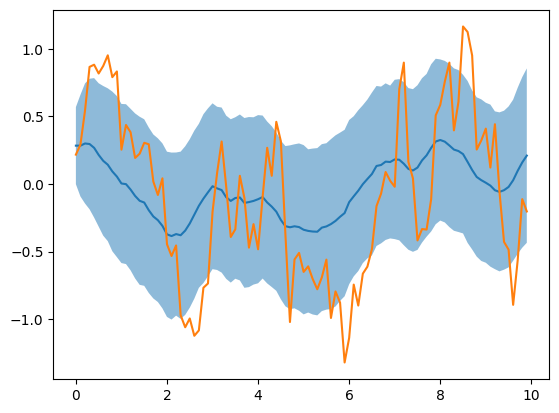

In [225]:
guide_data = predictive_guide(x_data.to(device)).detach().cpu()
plt.plot(t, guide_data.mean(dim=0))
plt.fill_between(t, guide_data.mean(dim=0) - guide_data.std(dim=0), guide_data.mean(dim=0) + guide_data.std(dim=0), alpha=.5)
plt.plot(t, x_data[0]);

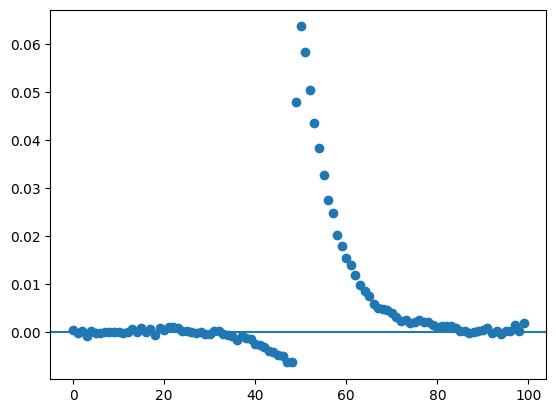

In [226]:
plt.scatter(torch.arange(100), pyro.param('weight').detach().cpu().reshape((-1,)))
plt.axhline(y=0);

In [227]:
pyro.param('cov_scale')

tensor(0.2984, device='cuda:0', grad_fn=<AddBackward0>)

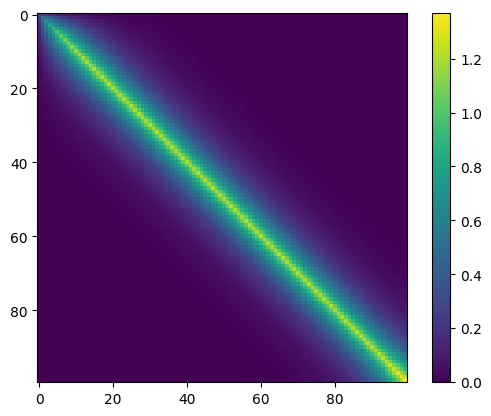

In [228]:
cov_ss_l = pyro.param("cov_ss_l").detach().cpu()
plt.imshow(torch.matmul(cov_ss_l, cov_ss_l.T) * pyro.param('cov_scale').detach().cpu())
plt.colorbar();

In [220]:
pyro.clear_param_store()
svi_losses = []

In [221]:
adam_params = {"lr": 1e-3}
optimizer = pyro.optim.Adam(adam_params)
svi = pyro.infer.SVI(
    predictive_model, 
    predictive_guide, 
    optimizer, 
    loss=pyro.infer.Trace_ELBO(num_particles=128, vectorize_particles=True)
)

In [222]:
def train_svi(svi, data):
    epoch_loss = 0.0
    epoch_loss += svi.step(data, subsample=128)
    return epoch_loss

In [223]:
n_steps = 5000
svi_data = data[:,1,:].to(device)
for step in range(n_steps):
    l = train_svi(svi, svi_data)
    svi_losses.append(l)
    (step + 1) % 100 == 0 and print(f"Finished step {step + 1}, loss={l}") #requests.post(webhook, json={"text": f"Finished step {step + 1}, loss={l}"})

Finished step 100, loss=618416.01171875
Finished step 200, loss=464797.3984375
Finished step 300, loss=361639.84765625
Finished step 400, loss=287405.3828125
Finished step 500, loss=231965.59765625
Finished step 600, loss=192432.197265625
Finished step 700, loss=162011.029296875
Finished step 800, loss=137192.0390625
Finished step 900, loss=119198.611328125
Finished step 1000, loss=102151.109375
Finished step 1100, loss=91265.4609375
Finished step 1200, loss=79462.25390625
Finished step 1300, loss=71224.921875
Finished step 1400, loss=64460.1953125
Finished step 1500, loss=58470.447265625
Finished step 1600, loss=53539.05078125
Finished step 1700, loss=49599.703125
Finished step 1800, loss=45377.11328125
Finished step 1900, loss=41916.20703125
Finished step 2000, loss=39294.421875
Finished step 2100, loss=37366.197265625
Finished step 2200, loss=35827.517578125
Finished step 2300, loss=33610.13671875
Finished step 2400, loss=32355.04296875
Finished step 2500, loss=32284.4375
Finished s

(20000.0, 80000.0)

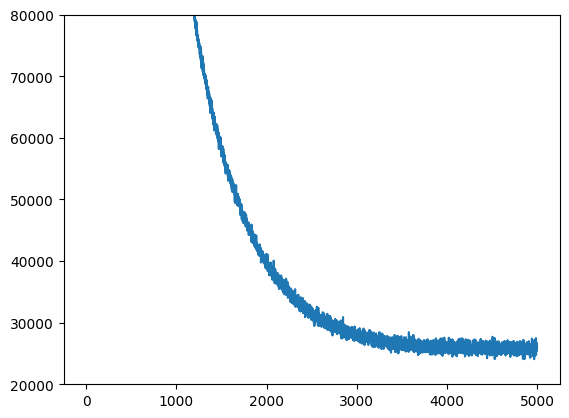

In [224]:
plt.plot(svi_losses)
plt.ylim(20000, 80000)
# plt.yscale('log');

In [182]:
importance_samples = []
importance_sampler = pyro.infer.Importance(predictive_model, guide=predictive_guide, num_samples=64)
for i in range(64):
    importance_sampler.run(svi_data)
    samples = torch.tensor(importance_sampler.log_weights)
    importance_samples.append(samples.detach().cpu())
importance_samples = torch.cat(importance_samples, 0)

In [183]:
log_p_of_x = importance_samples.logsumexp(0) - math.log(importance_samples.numel())
log_p_of_x

tensor(-25567.0840)

In [184]:
conditional_model = pyro.poutine.condition(predictive_model, data={"s_traj": data[:,0,:].to(device)})
trace= pyro.poutine.trace(conditional_model).get_trace(svi_data)
log_p_of_x_given_s = (trace.log_prob_sum() - trace.nodes['s_traj']['log_prob_sum']).detach().cpu()
log_p_of_x_given_s

tensor(-23246.3516)

In [185]:
((log_p_of_x_given_s - log_p_of_x) / data.size(0) - instantaneous_mi) / data.size(-1)

tensor(0.0223)

# Contrastive Learning

In [858]:
class ContrastiveModel(nn.Module):
    def __init__(self, L, stride=2, kernel_size=5):
        super().__init__()

        padding = (kernel_size - 1) // 2
        Lout = (L - 1) // stride + 1
        dim = 4 * ((Lout - 4) // 4 + 1)
        
        self.conv1 = nn.Conv1d(2, 16, kernel_size=kernel_size, stride=1, padding=padding, groups=2)
        self.conv2 = nn.Conv1d(16, 8, kernel_size=kernel_size, stride=stride, padding=padding, groups=2)
        
        self.bilinear = nn.Bilinear(dim, dim, 1, bias = False)
        
    def forward(self, data):
        z = data

        z = F.relu(self.conv1(z))
        z = F.relu(self.conv2(z))
        z = F.avg_pool1d(z, 4)

        z_s, z_x = z.split(z.size(-2)//2, dim=-2)
        
        z_s, z_x = z_s.flatten(1, -1), z_x.flatten(1, -1)

        n, d = z_s.size()
        z_s = z_s.unsqueeze(1).expand((n, n, d))
        z_x = z_x.unsqueeze(0).expand((n, n, d))
        
        return self.bilinear(z_s, z_x).squeeze(-1)
        

In [1008]:
class ContrastiveRnn(nn.Module):
    def __init__(self, rnn_dim=4, linear_dim=8, resample=20):
        super().__init__()
        
        self.resample = 10
        self.encoder_s = nn.Sequential(
            nn.Unflatten(-1, (1, -1)),
            nn.Conv1d(1, linear_dim, kernel_size=resample, padding=resample//2),
            nn.ReLU(),
            nn.Conv1d(linear_dim, linear_dim, kernel_size=resample, padding=resample//2),
            nn.ReLU(),
            nn.MaxPool1d(resample, padding=resample//2),
            nn.GRU(linear_dim, rnn_dim, num_layers=2, batch_first=True)
        )
        self.encoder_x = nn.Sequential(
            nn.Unflatten(-1, (1, -1)),
            nn.Conv1d(1, linear_dim, kernel_size=resample, padding=resample//2),
            nn.ReLU(),
            nn.Conv1d(linear_dim, linear_dim, kernel_size=resample, padding=resample//2),
            nn.ReLU(),
            nn.MaxPool1d(resample, padding=resample//2),
            nn.GRU(linear_dim, rnn_dim, num_layers=2, batch_first=True)
        )

        self.bilinear = nn.Bilinear(rnn_dim, rnn_dim, 1, bias = False)
    
    def forward(self, z):
        N, _, L = z.size()
        # z = z.view((N, 2, L//self.resample, self.resample))
        s, x = z.split(1, dim=1)
        
        z_s, _ = self.encoder_s(s.squeeze(1))
        z_x, _ = self.encoder_x(x.squeeze(1))

        z_s = z_s[:, -1, :]
        z_x = z_x[:, -1, :]

        N, d = z_s.size()

        z_s = z_s.unsqueeze(1).expand((N, N, d))
        z_x = z_x.unsqueeze(0).expand((N, N, d))
        
        return self.bilinear(z_s, z_x).squeeze(-1)

In [1009]:
# cmodel = ContrastiveModel(data.size(-1), kernel_size=25).to(device)
cmodel = ContrastiveRnn(rnn_dim=8, linear_dim=16, resample=20).to(device)
losses = []
mi_estimates = []
cmodel

ContrastiveRnn(
  (encoder_s): Sequential(
    (0): Unflatten(dim=-1, unflattened_size=(1, -1))
    (1): Conv1d(1, 16, kernel_size=(20,), stride=(1,), padding=(10,))
    (2): ReLU()
    (3): Conv1d(16, 16, kernel_size=(20,), stride=(1,), padding=(10,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=20, stride=20, padding=10, dilation=1, ceil_mode=False)
    (6): GRU(16, 8, num_layers=2, batch_first=True)
  )
  (encoder_x): Sequential(
    (0): Unflatten(dim=-1, unflattened_size=(1, -1))
    (1): Conv1d(1, 16, kernel_size=(20,), stride=(1,), padding=(10,))
    (2): ReLU()
    (3): Conv1d(16, 16, kernel_size=(20,), stride=(1,), padding=(10,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=20, stride=20, padding=10, dilation=1, ceil_mode=False)
    (6): GRU(16, 8, num_layers=2, batch_first=True)
  )
  (bilinear): Bilinear(in1_features=8, in2_features=8, out_features=1, bias=False)
)

In [1010]:
log_f = cmodel(train_data[:200]).detach().cpu()
plt.imshow(F.softmax(log_f, dim=-1))
plt.colorbar()

RuntimeError: input.size(-1) must be equal to input_size. Expected 16, got 6

In [984]:
# train_data, test_data = torch.utils.data.random_split(data, [0.8, 0.2])
simple_dataloader_train = DataLoader(train_data, batch_size=1000, shuffle=True)
simple_dataloader_test = DataLoader(test_data, batch_size=50, shuffle=False)
len(simple_dataloader_train)

8

We have the information bound

$$
I \geq I_{\mathrm{NCE}} = \mathbb{E}\left[ \frac{1}{K} \sum^K_{i=1} \ln \frac{\exp(f(s_i, x_i))}{\frac{1}{K} \sum^K_{j=1} \exp(f(s_i, x_j))} \right]
$$

which we try to maximize in our loss function. We can rewrite this expression as

$$
I_{\mathrm{NCE}} = \ln K + \mathbb{E}\left[ \frac{1}{K}  \sum^K_{i=1} \ln \frac{\exp(f(s_i, x_i))}{\sum^K_{j=1} \exp(f(s_i, x_j))} \right].
$$


In [995]:
optimizer = optim.Adam(cmodel.parameters(), lr=1e-3)
for i in range(500):
    epoch_loss = 0.0
    for x in simple_dataloader_train:
        K = x.size(0)
        log_f = cmodel(x.to(device))
        loss = - (log_f.diag() - log_f.logsumexp(dim=1)).mean()
        epoch_loss += loss.item()
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss /= len(simple_dataloader_train)

    with torch.no_grad():
        mi = 0.0
        for x in simple_dataloader_test:
            K = x.size(0)
            log_f = cmodel(x.to(device))
            val = math.log(K) + (log_f.diag() - log_f.logsumexp(dim=-1)).mean()
            mi += val.item()
    
        mi /= len(simple_dataloader_test)
    
    (i+1) % 50 == 0 and print(f"Step {i+1}: loss={epoch_loss:.4f} mi={mi:.4f}")
    losses.append(epoch_loss)
    mi_estimates.append(mi)

Step 50: loss=5.5831 mi=0.9234
Step 100: loss=5.5741 mi=0.9122
Step 150: loss=5.5677 mi=0.9088
Step 200: loss=5.5585 mi=0.9092
Step 250: loss=5.5503 mi=0.9071
Step 300: loss=5.5438 mi=0.8858
Step 350: loss=5.5403 mi=0.8912
Step 400: loss=5.5338 mi=0.8804
Step 450: loss=5.5265 mi=0.8783
Step 500: loss=5.5213 mi=0.8752


(0.0, 7.2526208147406575)

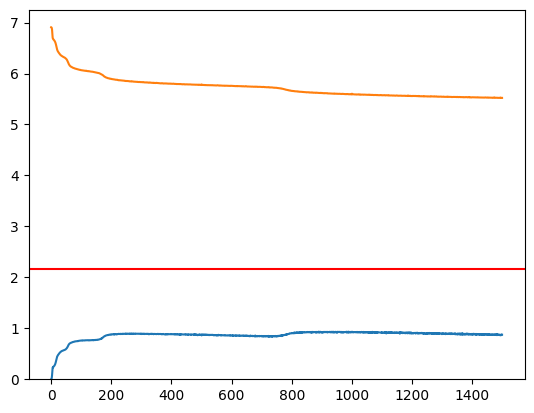

In [996]:
plt.plot(mi_estimates)
plt.plot(losses)
plt.axhline(instantaneous_mi.cpu() + exact_rate * delta_t * data.size(-1), color='red')
plt.ylim(0, None)

In [788]:
def estimate_mi(data, K = 50):
    mi_estimates = []
    for batch in data.split(K, dim=0):
        log_f = cmodel(batch)
        mi = math.log(K) + (log_f.diag() - log_f.logsumexp(dim=-1)).mean()
        mi_estimates.append(mi.cpu().detach())
    mi_estimates = np.array(mi_estimates)
    print(mi_estimates)
    return np.mean(mi_estimates), np.std(mi_estimates)

In [791]:
estimate_mi(data[1000:], K=200)

[-21.893353 -22.040386 -24.09161  -25.378868 -24.198015 -21.669697
 -22.191643 -21.750006 -24.457956 -20.546667 -21.980957 -23.467674
 -21.344063 -21.2604   -21.040379 -23.060667 -21.118103 -21.551712
 -21.75095  -23.146963 -25.588772 -20.734827 -22.87981  -24.297121
 -21.201736 -22.19152  -22.526836 -19.911234 -22.56279  -20.57167
 -20.961466 -22.149971 -21.383402 -21.843557 -22.336414 -23.077593
 -22.253584 -23.549105 -23.7016   -20.547731 -22.614319 -23.044558
 -22.116531 -23.208494 -23.889261]


(-22.379644, 1.291067)

# Miscellaneous

In [5]:
import os
import requests
from dotenv import load_dotenv, find_dotenv

In [6]:
load_dotenv()

True

In [9]:
webhook = os.environ.get("SLACK_WEBHOOK")

In [327]:
payload = {"text": "training finished"}

In [1945]:
r = requests.post(webhook, json=payload)